[2024/10/12 13:43:16 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
/home/jkgao/miniconda3/envs/mirg/lib/python3.9/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/jkgao/miniconda3/envs/mirg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 17/17 [00:00<00:00, 19.84it/s]
[2024/10/12 13:43:18 hloc INFO] Finished exporting features.
[2024/10/12 13:43:18 hloc INFO] Found 136 pairs.
[2024/10/12 13:43:18 hloc INFO] Matching local features with configuration

found 12/189 inlier correspondences.


100%|██████████| 1/1 [00:00<00:00, 13.44it/s]
[2024/10/12 13:43:54 hloc INFO] Finished exporting features.
[2024/10/12 13:43:54 hloc INFO] Found 17 pairs.
[2024/10/12 13:43:54 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
100%|██████████| 17/17 [00:00<00:00, 42.29it/s]
[2024/10/12 13:43:54 hloc INFO] Finished exporting matches.
[2024/10/12 13:43:54 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


found 1680/1822 inlier correspondences.


100%|██████████| 1/1 [00:00<00:00, 15.73it/s]
[2024/10/12 13:43:54 hloc INFO] Finished exporting features.
[2024/10/12 13:43:54 hloc INFO] Found 17 pairs.
[2024/10/12 13:43:54 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
100%|██████████| 17/17 [00:00<00:00, 52.13it/s]
[2024/10/12 13:43:55 hloc INFO] Finished exporting matches.


found 44/304 inlier correspondences.


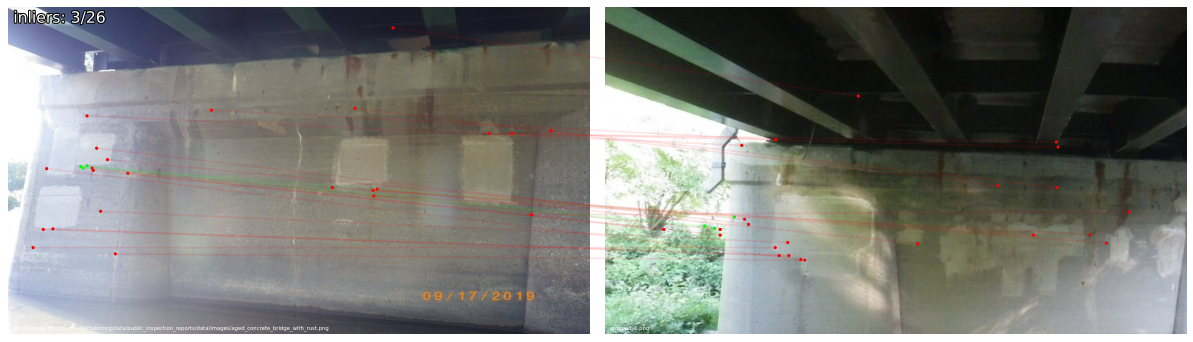

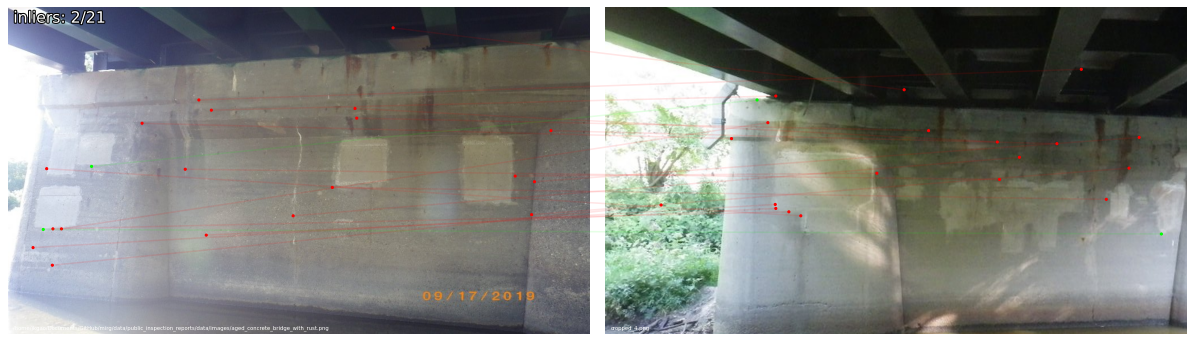

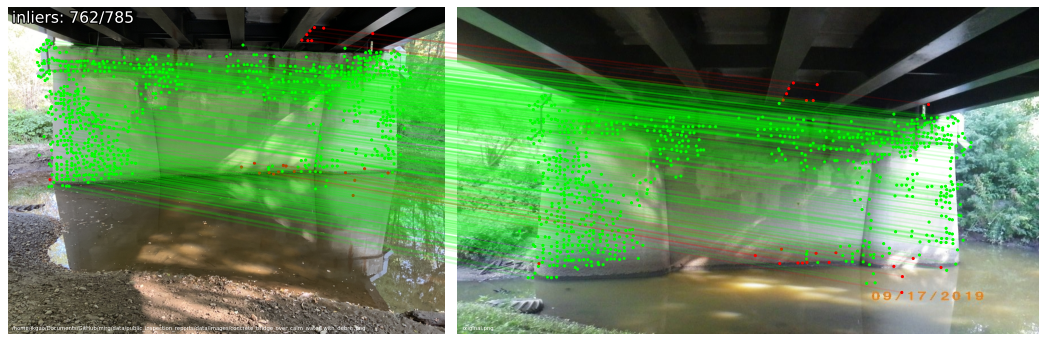

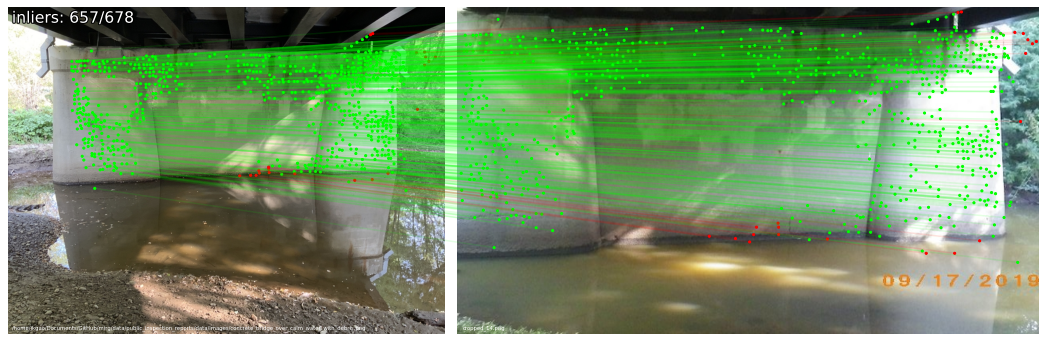

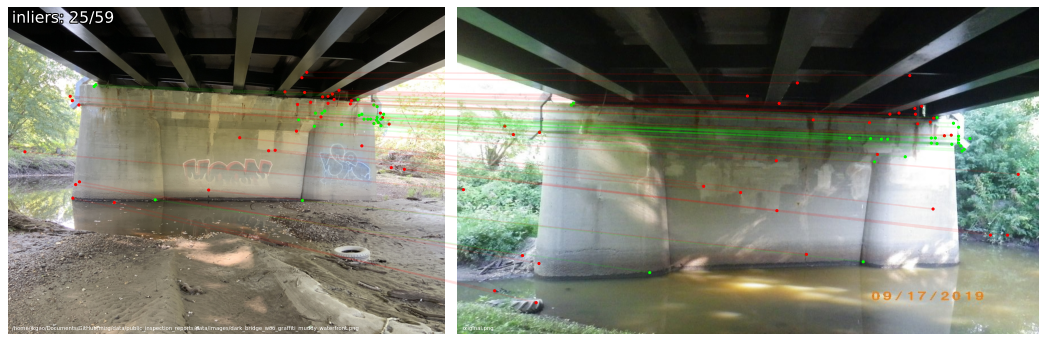

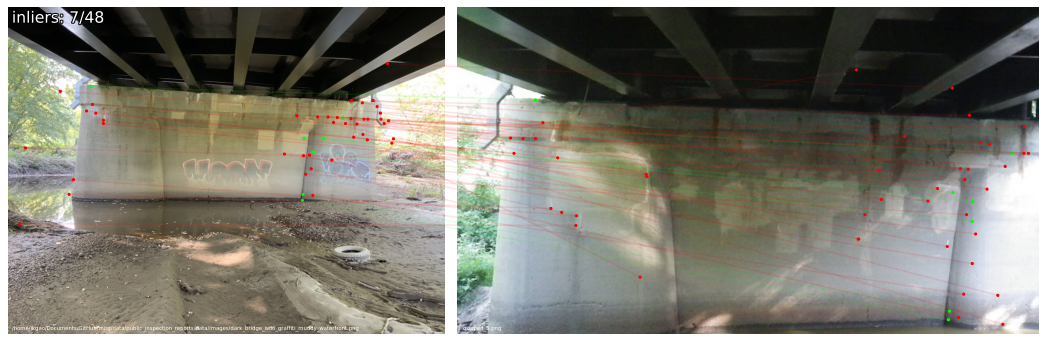

In [1]:
from models.hloc import Hloc
import json

hloc = Hloc()
with open(
    "/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/200030002008022/viewreport.ashx-3/images/metadata.json",
    "r",
) as f:
    metadata = json.load(f)

image_path = "/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/input/VT15-00020-CAMBRIDGE/images/concrete_bridge_underpass_waterway.png"
image_dir = "/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/images"

matches3, logs, model = hloc.is_same_location(
    image=image_path,
    image_dir=image_dir,
    min_inliers=100,
);

In [25]:
import numpy as np

def visualize_loc_from_log(
    loc,
    reconstruction=None,
):
    db_idx_list = []

    if loc.get("covisibility_clustering", False):
        # select the first, largest cluster if the localization failed
        loc = loc["log_clusters"][loc["best_cluster"] or 0]

    inliers = np.array(loc["PnP_ret"]["inliers"])
    mkp_q = loc["keypoints_query"]
    n = len(loc["db"])

    kp_idxs, kp_to_3D_to_db = loc["keypoint_index_to_db"]
    counts = np.zeros(n)
    dbs_kp_q_db = [[] for _ in range(n)]
    inliers_dbs = [[] for _ in range(n)]
    for i, (inl, (p3D_id, db_idxs)) in enumerate(zip(inliers, kp_to_3D_to_db)):
        track = reconstruction.points3D[p3D_id].track
        track = {el.image_id: el.point2D_idx for el in track.elements}
        for db_idx in db_idxs:
            counts[db_idx] += inl
            kp_db = track[loc["db"][db_idx]]
            dbs_kp_q_db[db_idx].append((i, kp_db))
            inliers_dbs[db_idx].append(inl)

    db_sort = np.argsort(-counts)
    db_idx = db_sort[0]
    db_kp_q_db = np.array(dbs_kp_q_db[db_idx])
    kp_q = mkp_q[db_kp_q_db[:, 0]]
    kp_db = np.array([reconstruction.images[loc["db"][db_idx]].points2D[i].xy for i in db_kp_q_db[:, 1]])

    db_image_name = reconstruction.images[loc["db"][db_idx]].name

    return kp_db, kp_q, db_image_name

26 26
cropped_0.png


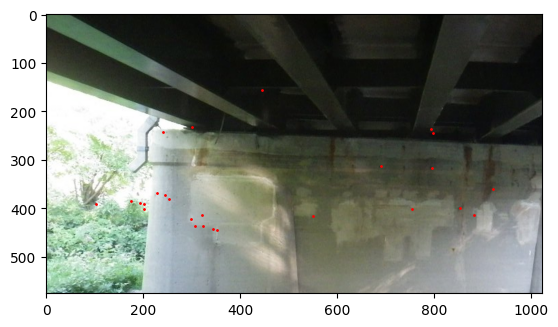

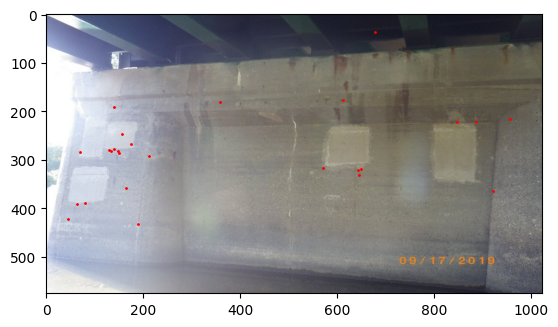

785 785
original.png


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
# Load the image
for i,name in enumerate(os.listdir(image_dir)):
    if not name.endswith('.png'):
        continue

    kp_db, kp_q, db_image_name = visualize_loc_from_log(logs[i], model)
    print(len(kp_db), len(kp_q))
    print(db_image_name)

    image = Image.open("outputs/hloc/images/" + db_image_name)
    for coords in kp_db:
        x = coords[0]
        y = coords[1]
        # Display the image using matplotlib
        plt.imshow(image)
        # Plot the point
        plt.plot(x, y, 'ro', markersize=1)  # 'ro' means red color and circle marker
    plt.show()

    query = os.path.join(image_dir, name)
    image = Image.open(query)
    for coords in kp_q:
        x = coords[0]
        y = coords[1]
        # Display the image using matplotlib
        plt.imshow(image)
        # Plot the point
        plt.plot(x, y, 'ro', markersize=1)  # 'ro' means red color and circle marker
    plt.show()